# LIBRARY

In [58]:
import os

# There are two ways to load the data from the PANDA dataset:
# Option 1: Load images using openslide
#import openslide
# Option 2: Load images using skimage (requires that tifffile is installed)
import skimage.io
import random
import seaborn as sns
import cv2

# General packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import PIL
from IPython.display import Image, display

# Plotly for the interactive viewer (see last section)
import plotly.graph_objs as go

from skimage.io import MultiImage,imsave,imread

In [89]:

!apt update && apt install -y openslide-tools
!pip install openslide-python

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:12 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,567 kB]
Hit:13 https://developer.download.nvidia.c

In [90]:
import openslide

In [65]:
import numpy as np 
import pandas as pd 

import os
import glob
import skimage.io

import skimage
import tifffile
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing

multiprocessing.cpu_count()

2

In [79]:

#BASIC
import numpy as np 
import pandas as pd 
import os

# DATA visualization
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from IPython.display import Image, display
from plotly import graph_objs as go
import plotly.express as px


import random
import collections

# LOADING DATASET

In [87]:
# Location of the training images

BASE_PATH = '/content/drive/MyDrive/PANDA'

# image and mask directories
data_dir = f'{BASE_PATH}/train_images'
mask_dir = f'{BASE_PATH}/train_label_masks'


# Location of training labels
#train = pd.read_csv(f'{BASE_PATH}/train.csv').set_index('image_id')
train = pd.read_csv(f'{BASE_PATH}/train.csv')
test = pd.read_csv(f'{BASE_PATH}/test.csv')
submission = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')

# DATA MATA

In [19]:
display(train.head())
print("-----------------------------------------------------------")
print("Shape of training data :", train.shape)
print("unique data provider :", len(train.data_provider.unique()))
print("unique isup_grade(target) :", len(train.isup_grade.unique()))
print("unique gleason_score :", len(train.gleason_score.unique()))

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


-----------------------------------------------------------
Shape of training data : (10616, 4)
unique data provider : 2
unique isup_grade(target) : 6
unique gleason_score : 10


In [20]:
train.drop([72],inplace=True) #Mislabelled
train['gleason_score'] = train['gleason_score'].apply(lambda x: "0+0" if x=="negative" else x)

In [21]:
temp = train.groupby('isup_grade').count()['image_id'].reset_index().sort_values(by='image_id',ascending=False)
temp.style.background_gradient(cmap='Purples')

,isup_grade,image_id
0,0,2892
1,1,2666
2,2,1342
4,4,1249
3,3,1242
5,5,1224


In [22]:
fig = go.Figure(go.Funnelarea(
    text =temp.isup_grade,
    values = temp.image_id,
    title = {"position": "top center", "text": "Funnel-Chart of ISUP_grade Distribution"}
    ))
fig.show()

In [26]:
fig = px.bar(temp, x='isup_grade', y='image_id',
             hover_data=['image_id', 'isup_grade'], color='image_id',
             labels={'pop':'population of Canada'}, height=400)
fig.show()

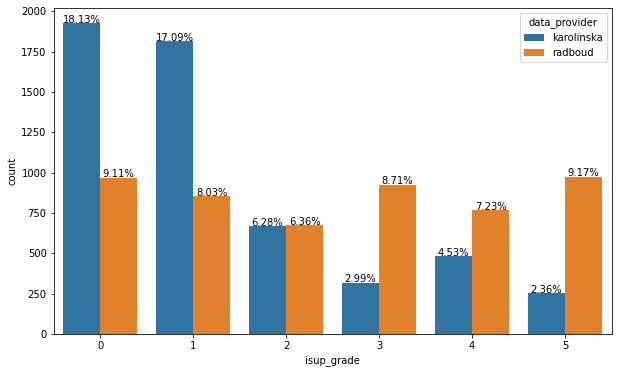

In [27]:
fig = plt.figure(figsize=(10,6))
ax = sns.countplot(x="isup_grade", hue="data_provider", data=train)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,
                height +3,
                '{:1.2f}%'.format(100*height/10616),
                ha="center")

In [28]:
temp = train.groupby('gleason_score').count()['image_id'].reset_index().sort_values(by='image_id',ascending=False)
temp.style.background_gradient(cmap='Reds')

,gleason_score,image_id
0,0+0,2892
1,3+3,2666
2,3+4,1341
4,4+3,1243
5,4+4,1126
6,4+5,849
8,5+4,248
9,5+5,127
3,3+5,80
7,5+3,43


In [29]:
fig = go.Figure(go.Funnelarea(
    text =temp.gleason_score,
    values = temp.image_id,
    title = {"position": "top center", "text": "Funnel-Chart of ISUP_grade Distribution"}
    ))
fig.show()

In [30]:
fig = px.bar(temp, x='gleason_score', y='image_id',
             hover_data=['image_id', 'gleason_score'], color='image_id',
             labels={'pop':'population of Canada'}, height=400)
fig.show()

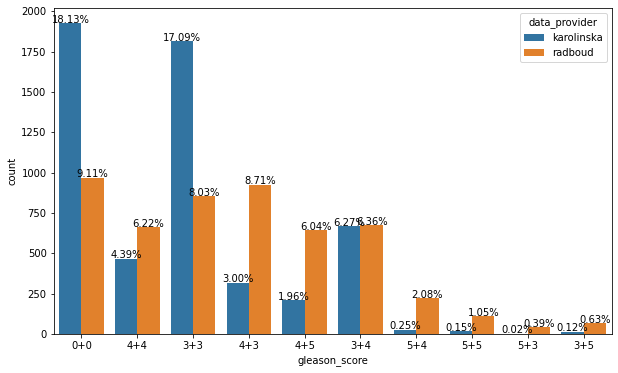

In [31]:
'''
Visualizing the GLEASON_SCORE distribution wrt Data_providers
'''

fig = plt.figure(figsize=(10,6))
ax = sns.countplot(x="gleason_score", hue="data_provider", data=train)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/10616),
                ha="center")

In [38]:
# Open the image (does not yet read the image into memory)
#example = openslide.OpenSlide(os.path.join(BASE_FOLDER+"train_images", '005e66f06bce9c2e49142536caf2f6ee.tiff'))

# Read a specific region of the image starting at upper left coordinate (x=17800, y=19500) on level 0 and extracting a 256*256 pixel patch.
# At this point image data is read from the file and loaded into memory.
#patch = example.read_region((17800,19500), 0, (256, 256))

# Display the image
#display(patch)

# Close the opened slide after use
#example.close()

In [39]:
train = train.set_index('image_id')
train.head()

,data_provider,isup_grade,gleason_score
image_id,,,
0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [43]:
#The data set consists of 100 observations and 10 variables (out of which 8 numeric variables and one categorical variable and is ID)
import pandas as pd
import numpy as np
data=pd.read_csv(f'{BASE_PATH}/Prostate_Cancer.csv')
data.head()

,id,diagnosis_result,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
0,1,M,23,12,151,954,0.143,0.278,0.242,0.079
1,2,B,9,13,133,1326,0.143,0.079,0.181,0.057
2,3,M,21,27,130,1203,0.125,0.160,0.207,0.060
3,4,M,14,16,78,386,0.070,0.284,0.260,0.097
4,5,M,9,19,135,1297,0.141,0.133,0.181,0.059


In [44]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 100 non-null    int64  
 1   diagnosis_result   100 non-null    object 
 2   radius             100 non-null    int64  
 3   texture            100 non-null    int64  
 4   perimeter          100 non-null    int64  
 5   area               100 non-null    int64  
 6   smoothness         100 non-null    float64
 7   compactness        100 non-null    float64
 8   symmetry           100 non-null    float64
 9   fractal_dimension  100 non-null    float64
dtypes: float64(4), int64(5), object(1)
memory usage: 7.9+ KB


In [45]:
data=data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 100 non-null    int64  
 1   diagnosis_result   100 non-null    object 
 2   radius             100 non-null    int64  
 3   texture            100 non-null    int64  
 4   perimeter          100 non-null    int64  
 5   area               100 non-null    int64  
 6   smoothness         100 non-null    float64
 7   compactness        100 non-null    float64
 8   symmetry           100 non-null    float64
 9   fractal_dimension  100 non-null    float64
dtypes: float64(4), int64(5), object(1)
memory usage: 8.6+ KB


In [46]:
from sklearn.preprocessing import LabelEncoder
enc=LabelEncoder()
data['diagnosis_result']=enc.fit_transform(data['diagnosis_result'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 100 non-null    int64  
 1   diagnosis_result   100 non-null    int64  
 2   radius             100 non-null    int64  
 3   texture            100 non-null    int64  
 4   perimeter          100 non-null    int64  
 5   area               100 non-null    int64  
 6   smoothness         100 non-null    float64
 7   compactness        100 non-null    float64
 8   symmetry           100 non-null    float64
 9   fractal_dimension  100 non-null    float64
dtypes: float64(4), int64(6)
memory usage: 8.6 KB


In [47]:
data.describe()

,id,diagnosis_result,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,50.500000,0.620000,16.850000,18.230000,96.780000,702.880000,0.102730,0.126700,0.193170,0.064690
std,29.011492,0.487832,4.879094,5.192954,23.676089,319.710895,0.014642,0.061144,0.030785,0.008151
min,1.000000,0.000000,9.000000,11.000000,52.000000,202.000000,0.070000,0.038000,0.135000,0.053000
25%,25.750000,0.000000,12.000000,14.000000,82.500000,476.750000,0.093500,0.080500,0.172000,0.059000
50%,50.500000,1.000000,17.000000,17.500000,94.000000,644.000000,0.102000,0.118500,0.190000,0.063000
75%,75.250000,1.000000,21.000000,22.250000,114.250000,917.000000,0.112000,0.157000,0.209000,0.069000
max,100.000000,1.000000,25.000000,27.000000,172.000000,1878.000000,0.143000,0.345000,0.304000,0.097000


In [49]:
data.isnull().sum()

id                   0
diagnosis_result     0
radius               0
texture              0
perimeter            0
area                 0
smoothness           0
compactness          0
symmetry             0
fractal_dimension    0
dtype: int64

In [55]:
def random_color():
    return "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) 

def draw_bar(x_data,y_data,x_axis,y_axis,title):
    
    plt.style.use('fast')
    plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

    x_pos = [i for i, _ in enumerate(x_data)]

    plt.bar(x_pos, y_data, color=random_color())
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title(title)

    plt.xticks(x_pos, x_data)

    plt.show()
    
def draw_column_bar(column_label,x_axis,y_axis,title):
    
    count = collections.Counter(train[column_label])
    labels = list(count)
    occur = [count[x] for x in labels]

    draw_bar(labels,occur,x_axis,y_axis,title)

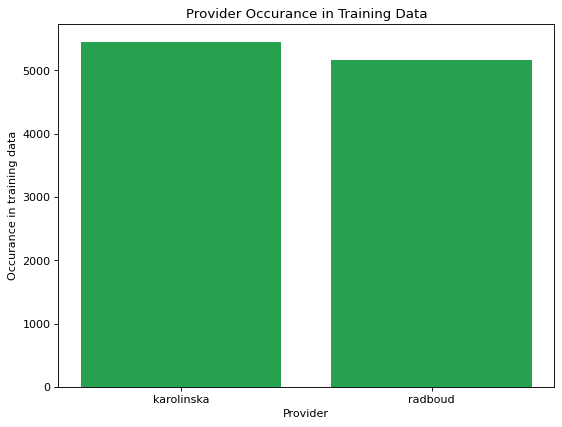

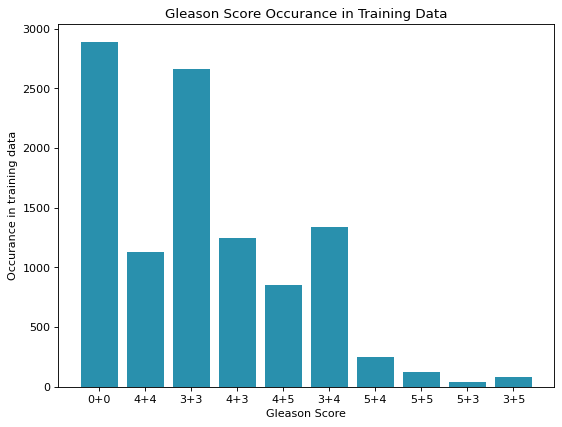

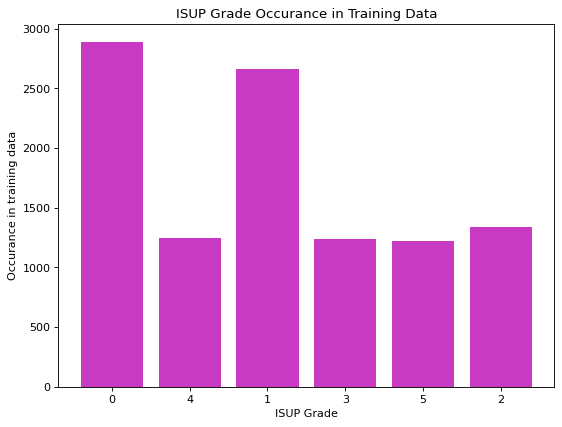

In [56]:
draw_column_bar('data_provider',"Provider","Occurance in training data","Provider Occurance in Training Data")
draw_column_bar('gleason_score',"Gleason Score","Occurance in training data","Gleason Score Occurance in Training Data")
draw_column_bar('isup_grade',"ISUP Grade","Occurance in training data","ISUP Grade Occurance in Training Data")